In [1]:
from scipy.optimize import minimize

from qiskit import *
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators.state_fns import StateFn, CircuitStateFn
from qiskit.aqua.operators.expectations import PauliExpectation, AerPauliExpectation
from qiskit.aqua.operators.converters import CircuitSampler

import numpy as np
import matplotlib.pyplot as plt

# ハミルトニアンを定義(by OpenFermion)

In [15]:
# !pip install qulacs pyscf openfermion openfermionpyscf

In [13]:
# from openfermion.transforms import get_fermion_operator, jordan_wigner
# from openfermion.transforms import get_sparse_operator
# from openfermion.hamiltonians import MolecularData
# from openfermionpyscf import run_pyscf
# from pyscf import fci

In [14]:
# #define constants
# # 分子軌道を表現するための基底関数(Slator Type Orbital - 3 gaussian)
# basis = "sto-3g"
# # スピン多重度
# multiplicity = 1
# # 全電荷
# charge = 0
# # 原子核配置
# distance = 0.977
# geometry = [["H", [0, 0, 0]], ["H", [0, 0, distance]]]
# # 計算結果の保存場所
# description = "tmp"
# molecule = MolecularData(geometry, basis, multiplicity, charge, description)
# molecule = run_pyscf(molecule, run_scf=1, run_fci=1)

# n_qubit = molecule.n_qubits
# n_electron = molecule.n_electrons
# # get_molecular_hamiltonianで第二量子化形式のハミルトニアンを計算
# fermionic_hamiltonian = get_fermion_operator(
#     molecule.get_molecular_hamiltonian())
# # Jordan-Wigner変換によりハミルトニアンをパウリ行列のテンソル積形式に変換
# jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

# # 励起状態も考慮するため励起状態の厳密解を求める
# hamiltonian_matrix = get_sparse_operator(jw_hamiltonian)
# from scipy.sparse.linalg import eigsh
# eigval, eigvec = eigsh(hamiltonian_matrix, k=2, which="SA")

In [18]:
# print(jw_hamiltonian)

(-0.31349601534094224+0j) [] +
(-0.048834726365406485+0j) [X0 X1 Y2 Y3] +
(0.048834726365406485+0j) [X0 Y1 Y2 X3] +
(0.048834726365406485+0j) [Y0 X1 X2 Y3] +
(-0.048834726365406485+0j) [Y0 Y1 X2 X3] +
(0.13978238294522735+0j) [Z0] +
(0.1576263055158343+0j) [Z0 Z1] +
(0.10745382591353006+0j) [Z0 Z2] +
(0.15628855227893657+0j) [Z0 Z3] +
(0.13978238294522735+0j) [Z1] +
(0.15628855227893657+0j) [Z1 Z2] +
(0.10745382591353006+0j) [Z1 Z3] +
(-0.13686895093682833+0j) [Z2] +
(0.16419290100986608+0j) [Z2 Z3] +
(-0.13686895093682833+0j) [Z3]


# ハミルトニアンを定義(by Qiskit Chemistry)

In [2]:
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
from qiskit.chemistry.transformations import FermionicTransformation,FermionicTransformationType, FermionicQubitMappingType

molecule = Molecule(geometry=[['H', [0., 0., 0.]], ['H', [0., 0., 0.977]]], charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
transformation = FermionicTransformation(
    transformation=FermionicTransformationType.FULL,
    qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER,
    two_qubit_reduction=False,
    freeze_core=False)
qubit_op, _ = transformation.transform(driver)
print(qubit_op)

SummedOp([
  -0.8551308269274315 * IIII,
  0.13978238294522738 * IIIZ,
  -0.13686895093682827 * IIZI,
  0.13978238294522735 * IZII,
  -0.13686895093682835 * ZIII,
  0.10745382591353006 * IIZZ,
  0.15762630551583431 * IZIZ,
  0.04883472636540648 * XXYY,
  0.04883472636540648 * YYYY,
  0.04883472636540648 * XXXX,
  0.04883472636540648 * YYXX,
  0.1562885522789365 * ZIIZ,
  0.1562885522789365 * IZZI,
  0.16419290100986614 * ZIZI,
  0.10745382591353006 * ZZII
])


In [4]:
# ハミルトニアンをOpenFermionから求めたものを使ってみる
from qiskit.aqua.operators.list_ops import SummedOp
from qiskit.aqua.operators import I,X,Y,Z
qubit_op = SummedOp([
  -0.313496015340942 * I^I^I^I,
  -0.136868950936828 * I^I^I^Z,
  -0.136868950936828* I^I^Z^I,
  0.139782382945227 * I^Z^I^I,
  0.139782382945227 * Z^I^I^I,
  0.164192901009866 * I^I^Z^Z,
  0.10745382591353 * I^Z^I^Z,
  -0.0488347263654064 * X^X^Y^Y,
  0.048834726365406485 * X^Y^Y^X,
  0.048834726365406485 * Y^X^X^Y,
  -0.0488347263654064 * Y^Y^X^X,
  0.1562885522789365 * Z^I^I^Z,
  0.1562885522789365 * I^Z^Z^I,
  0.10745382591353 * Z^I^Z^I,
  0.157626305515834 * Z^Z^I^I
])

# 厳密解を計算(numpy)

In [5]:
from qiskit.chemistry.algorithms import NumPyEigensolverFactory
from qiskit.chemistry.algorithms.excited_states_solvers import ExcitedStatesEigensolver

numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
numpy_excited_states_calculation = ExcitedStatesEigensolver(transformation, numpy_solver)
numpy_results = numpy_excited_states_calculation.solve(driver)
print(numpy_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.647568163891
  - computed part:      -1.647568163891
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.541634811586
> Total ground state energy (Hartree): -1.105933352305
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -0.883941675261
> Total excited state energy (Hartree): -0.342306863674
  2: 
* Electronic excited state energy (Hartree): -0.474024589682
> Total excited state energy (Hartree): 0.067610221904
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  2:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.84626242]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.84626242]
    - computed part:      [0.0  0.0  1.84626242]
    - frozen energy part: [0.0  

One can see from these results that one state is missing from the NumPy results. The reason for this is because the spin is also used as a filter and only singlet states are shown. In the following we use a custom filter function to check consistently our results and only filter out states with incorrect number of particle (in this case the number of particle is 2).

In [6]:
def filter_criterion(eigenstate, eigenvalue, aux_values):
    return np.isclose(aux_values[0][0], 2.)

new_numpy_solver = NumPyEigensolverFactory(filter_criterion=filter_criterion)
new_numpy_excited_states_calculation = ExcitedStatesEigensolver(transformation, new_numpy_solver)
new_numpy_results = new_numpy_excited_states_calculation.solve(driver)

print(new_numpy_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.647568163891
  - computed part:      -1.647568163891
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.541634811586
> Total ground state energy (Hartree): -1.105933352305
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -1.274619486184
> Total excited state energy (Hartree): -0.732984674597
  2: 
* Electronic excited state energy (Hartree): -1.274619486184
> Total excited state energy (Hartree): -0.732984674597
  3: 
* Electronic excited state energy (Hartree): -1.274619486184
> Total excited state energy (Hartree): -0.732984674597
  4: 
* Electronic excited state energy (Hartree): -0.883941675261
> Total excited state energy (Hartree): -0.342306863674
  5: 
* Electronic excited state energy (Hartree): -0.474024589682
> Total excited state energy (Hartree): 0.067610221904
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000

# SSVQEアルゴリズムの実装(qiskit)

In [7]:
n_qubit = transformation.molecule_info.get('num_orbitals')
depth = n_qubit
print(n_qubit)

4


In [8]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:

    """
    qc = QuantumCircuit(n_qubit)
    qc.ry(theta_list[-2], 0)
    qc.rz(theta_list[-1], 0)
    for d in range(depth):
        for i in range(n_qubit):
            qc.ry(theta_list[2*i+2*n_qubit*d], i)
            qc.rz(theta_list[2*i+1+2*n_qubit*d], i)
        for i in range(n_qubit//2):
            qc.cz(2*i, 2*i+1)
        for i in range(n_qubit//2-1):
            qc.cz(2*i+1, 2*i+2)
    for i in range(n_qubit):
        qc.ry(theta_list[2*i+2*n_qubit*depth], i)
        qc.rz(theta_list[2*i+1+2*n_qubit*depth], i)

    return qc

# コスト関数の定義

In [9]:
def get_expectation(state, thCircuitStateFneta_list):
    ansatz = he_ansatz_circuit(n_qubit, depth, theta_list)
    psi = CircuitStateFn(state+ansatz)

    # define your backend or quantum instance (where you can add settings)
    backend = Aer.get_backend('qasm_simulator') 
    q_instance = QuantumInstance(backend, shots=1024)

    # define the state to sample
    measurable_expression = StateFn(qubit_op, is_measurement=True).compose(psi)

    # convert to expectation value
    ## (~psi @ hamiltonianan @ psi).eval() は遅いから使わない
#     expectation = PauliExpectation().convert(measurable_expression)  
    expectation = AerPauliExpectation().convert(measurable_expression)

    # get state sampler (you can also pass the backend directly)
    sampler = CircuitSampler(q_instance).convert(expectation) 

    # evaluate
    return sampler.eval().real

def cost(theta_list):
    # 初期状態の準備
    # state0:|0000>
    qc0 = QuantumCircuit(n_qubit)
    # state1:|0001>
    qc1 = QuantumCircuit(n_qubit)
    qc1.x(0)
    return get_expectation(qc0 , theta_list) + 0.5*get_expectation(qc1, theta_list)

In [10]:
init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
cost(init_theta_list)

0.4512259496975318

In [11]:
exp_history0 = []
exp_history1 = []
def callback(theta_list):
    # 初期状態の準備
    # state0:|0000>
    qc0 = QuantumCircuit(n_qubit)
    # state1:|0001>
    qc1 = QuantumCircuit(n_qubit)
    qc1.x(0)
    exp_history0.append(get_expectation(qc0, theta_list))
    exp_history1.append(get_expectation(qc1, theta_list))
    
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list, method=method, callback=callback)

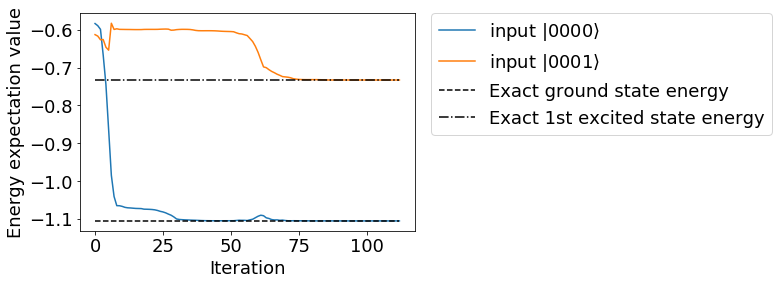

In [12]:
plt.rcParams["font.size"] = 18
plt.plot(exp_history0, label=r"input $|0000\rangle$")
plt.plot(exp_history1, label=r"input $|0001\rangle$")
plt.plot(range(len(exp_history0)), [-1.105933352305]*len(exp_history0), linestyle="dashed", color="black", label="Exact ground state energy")
plt.plot(range(len(exp_history1)), [-0.732984674597]*len(exp_history1), linestyle="-.", color="black", label="Exact 1st excited state energy")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()